In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import ee
import geemap
from functools import partial

from matplotlib.ticker import Formatter, LinearLocator

import scipy
import scipy.io

(24, 200)


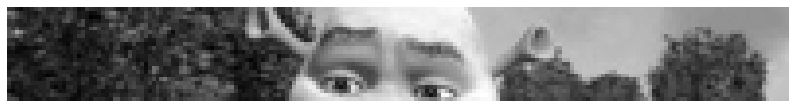

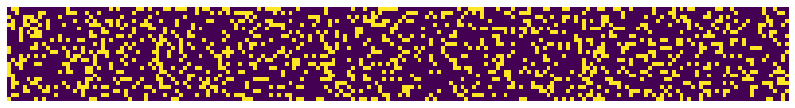

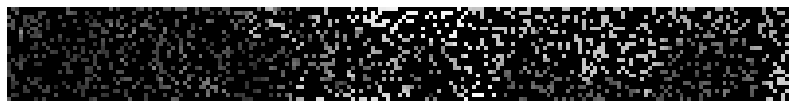

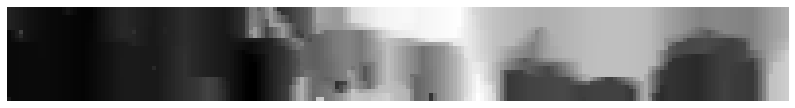

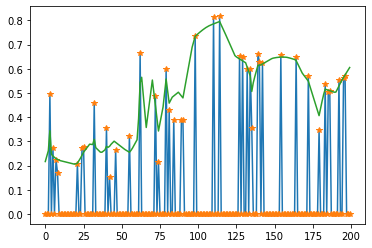

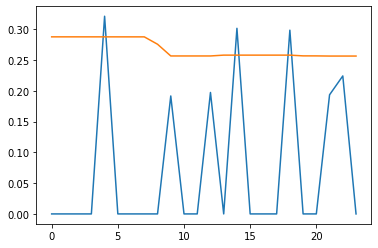

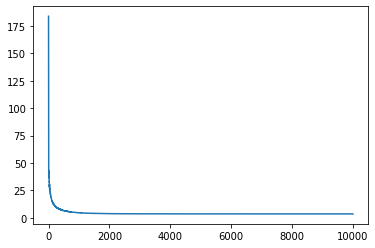

In [12]:
from os import chdir
chdir("../Piecewise Constant Denoising/");
%run "../Piecewise Constant Denoising/Khalid_Chambolle_Pock_LinearAndConstant.ipynb"
chdir("../EarthEngine");

In [3]:
df = pd.read_csv("Lhasa/Lhasa_Data-CC-80.csv", index_col=0);
df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);

tiles = df["Tile_ID"].unique();
tiles.sort();
tiles.shape

(1944,)

In [5]:
df_s = pd.read_csv("Lhasa/Lhasa_Sentinel_Data-CC-80.csv", index_col=0);
df_s["SENSING_TIME"] = df_s["SENSING_TIME"].map(partial(pd.to_datetime, unit='ms'));
tiles = df_s["Tile_ID"].unique();
tiles.sort();

tiles.shape

(1004,)

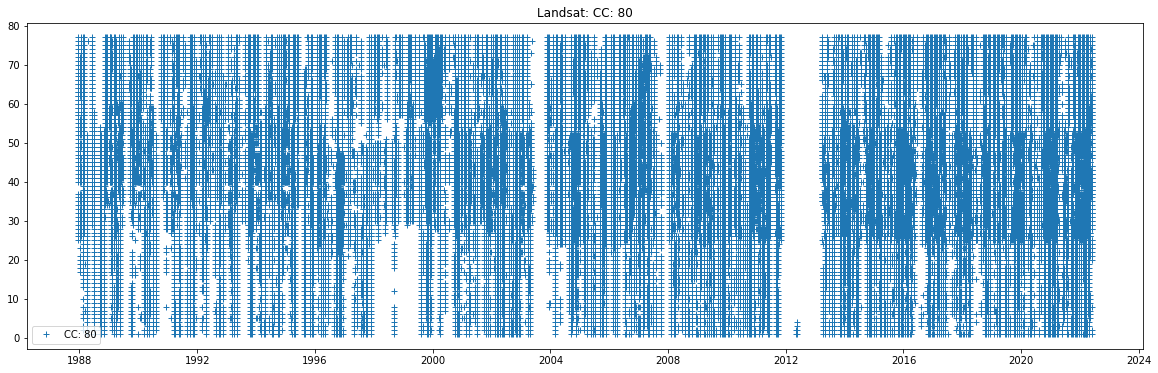

In [6]:
# Sparsity plot

# Barbara's opinion on CLOUD_FILTER
# - 
# - 

# GET DF100
# Work with reduced subset of DGOs.
# LOOK AT DATAPOINT OVERLAP
def plot_cc(name):
    df = pd.read_csv(f"Lhasa/Lhasa_Data-CC-{name}.csv", index_col=0);
    df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
    df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
    data = df; #df[["ID", "SENSING_TIME"]];
    plt.figure(figsize=(20,6));
    plt.title(f"Landsat: CC: {name}");
    plt.plot(data["SENSING_TIME"], data["ID"], '+', label=f"CC: {name}");
    return data


# df100 = plot_cc(100);

# df95 = plot_cc(95);
# # df_diff = pd.concat([df100, df95]).drop_duplicates(keep=False);
# # print(df95.shape, df_diff.shape)
# # plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 100");
# plt.legend();

df80 = plot_cc(80);
# df_diff = pd.concat([df95, df80]).drop_duplicates(keep=False);
# plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 95");
plt.legend();

# df50 = plot_cc(50);
# df_diff = pd.concat([df95, df50]).drop_duplicates(keep=False);
# plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 95");
# plt.legend();

# df25 = plot_cc(25);
# df_diff = pd.concat([df95, df25]).drop_duplicates(keep=False);
# plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC: 95");
# plt.legend();

# print(df80.shape, df50.shape, df25.shape);

# df_c = df[df["ID"] == 1].sort_values("SENSING_TIME");

(73474, 9) (44773, 9) (21819, 9)


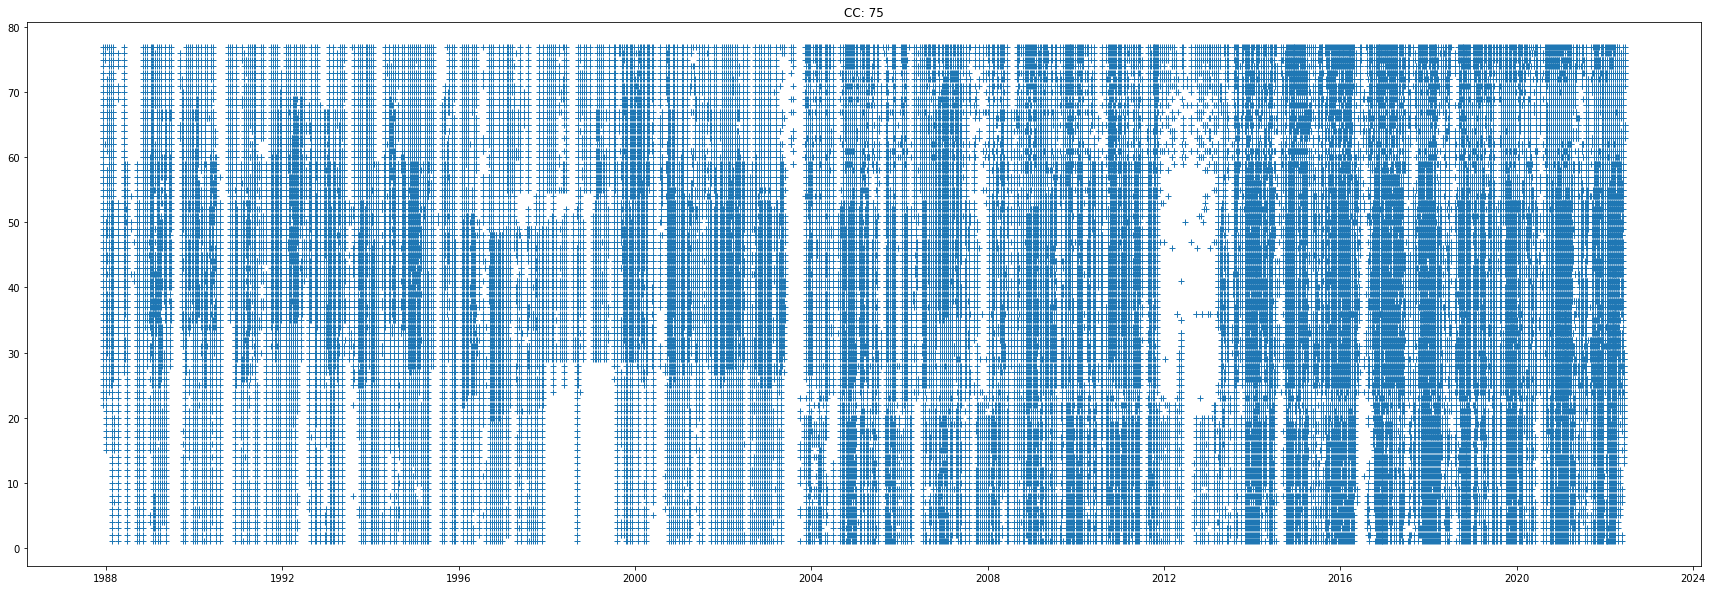

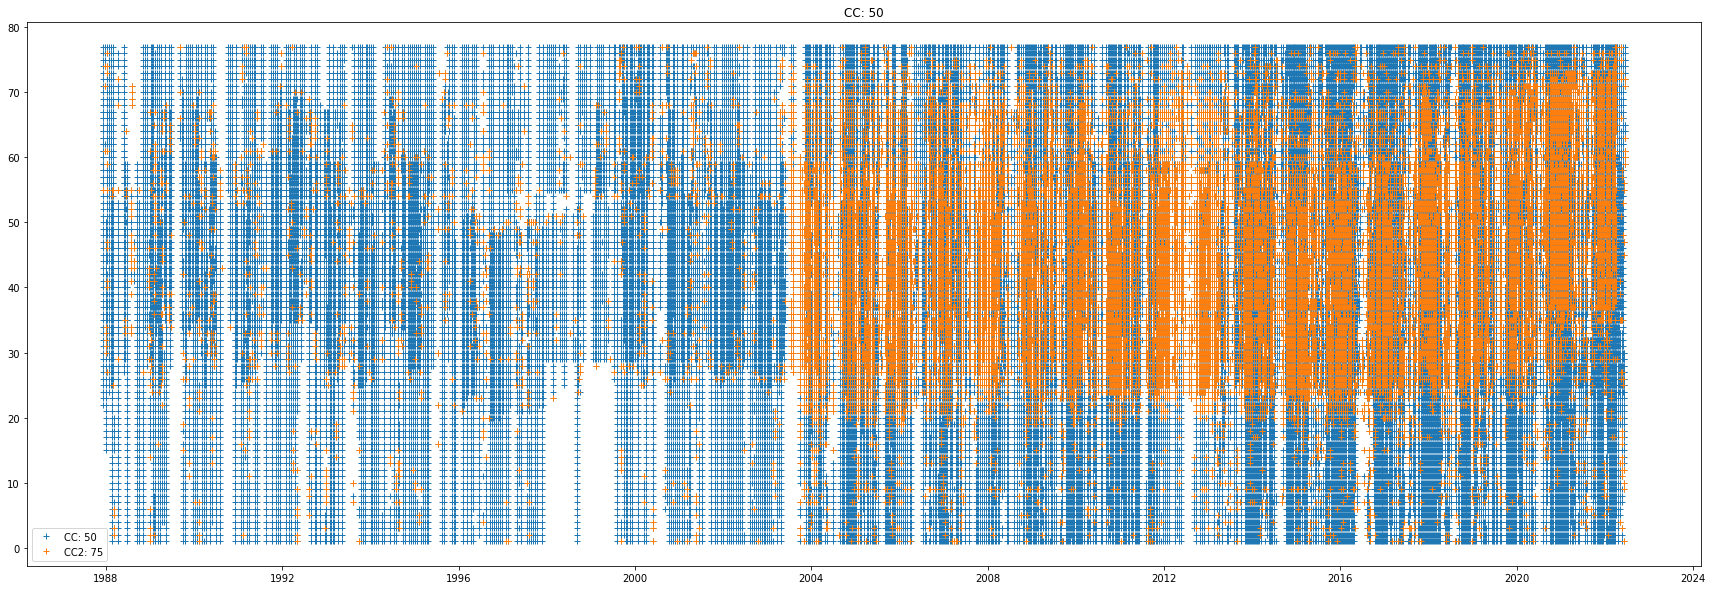

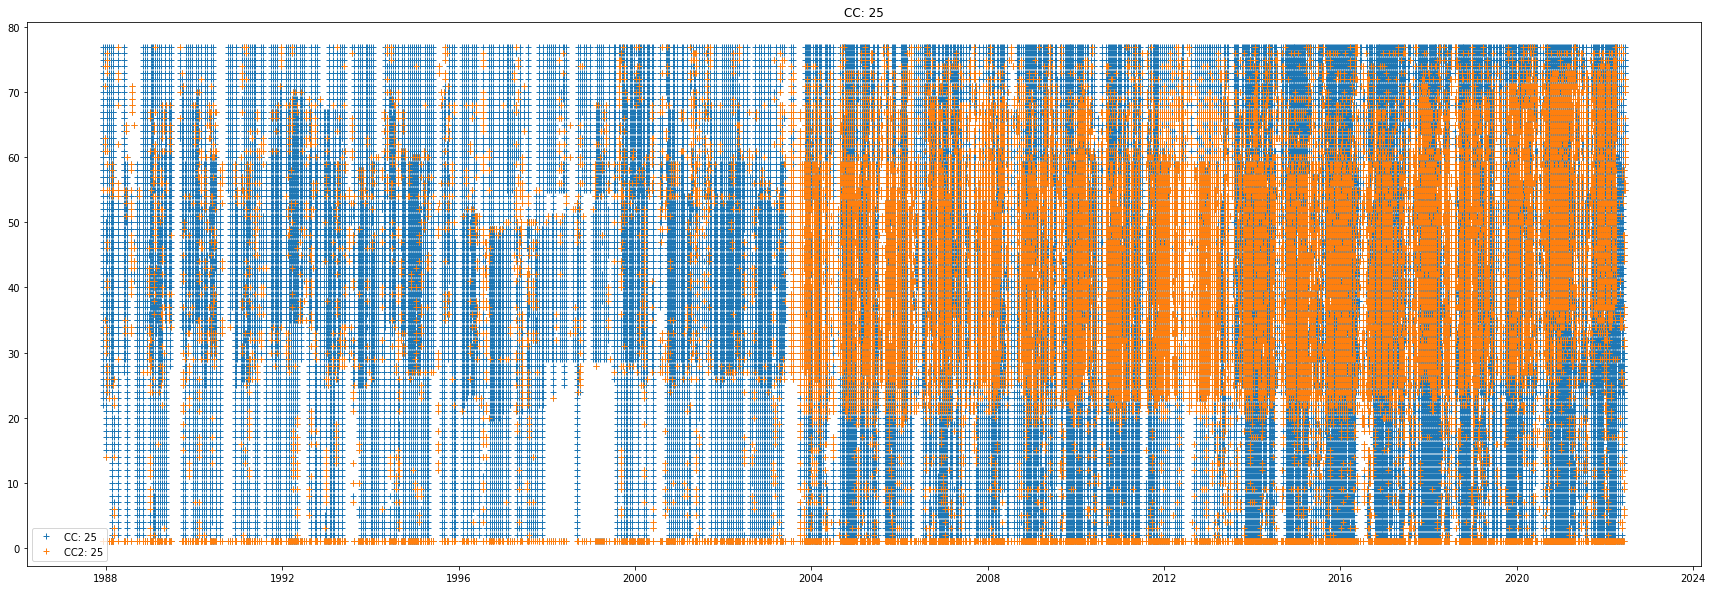

In [33]:
# Sparsity plot

# Barbara's opinion on CLOUD_FILTER
# - 
# - 

# GET DF100
# Work with reduced subset of DGOs.
# LOOK AT DATAPOINT OVERLAP

def plot_cc(name):
    df = pd.read_csv(f"Lhasa/Lhasa_Data-CC2-{name}.csv", index_col=0);
    df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
    df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
    data = df; #df[["ID", "SENSING_TIME"]];
    plt.figure(figsize=(30, 10));
    plt.title(f"CC: {name}");
    plt.plot(data["SENSING_TIME"], data["ID"], '+', label=f"CC: {name}");
    return data


dfs75 = plot_cc(75);

dfs50 = plot_cc(50);
df_diff = pd.concat([dfs75, dfs50]).drop_duplicates(keep=False);
plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC2: 75");
plt.legend();

dfs25 = plot_cc(25);
df_diff = pd.concat([dfs75, dfs25]).drop_duplicates(keep=False);
plt.plot(df_diff["SENSING_TIME"], df_diff["ID"], '+', label="CC2: 25");
plt.legend();

print(df75.shape, df50.shape, df25.shape);
# df_c = df[df["ID"] == 1].sort_values("SENSING_TIME");

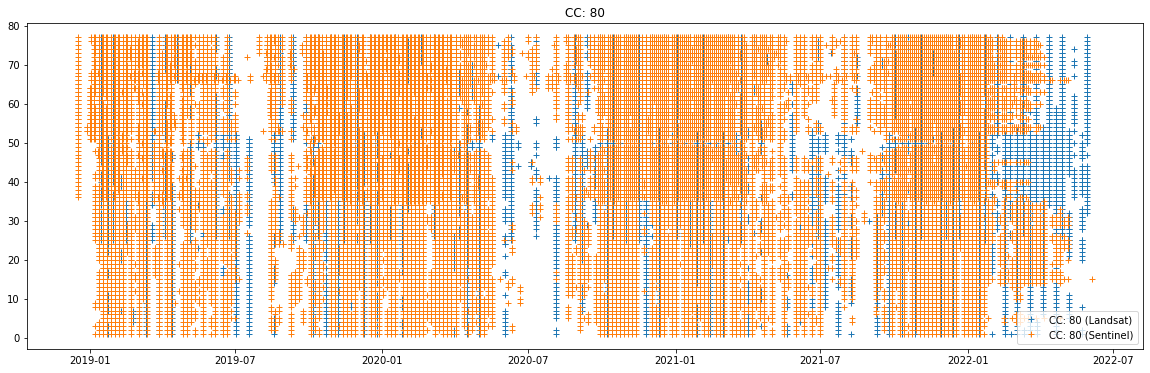

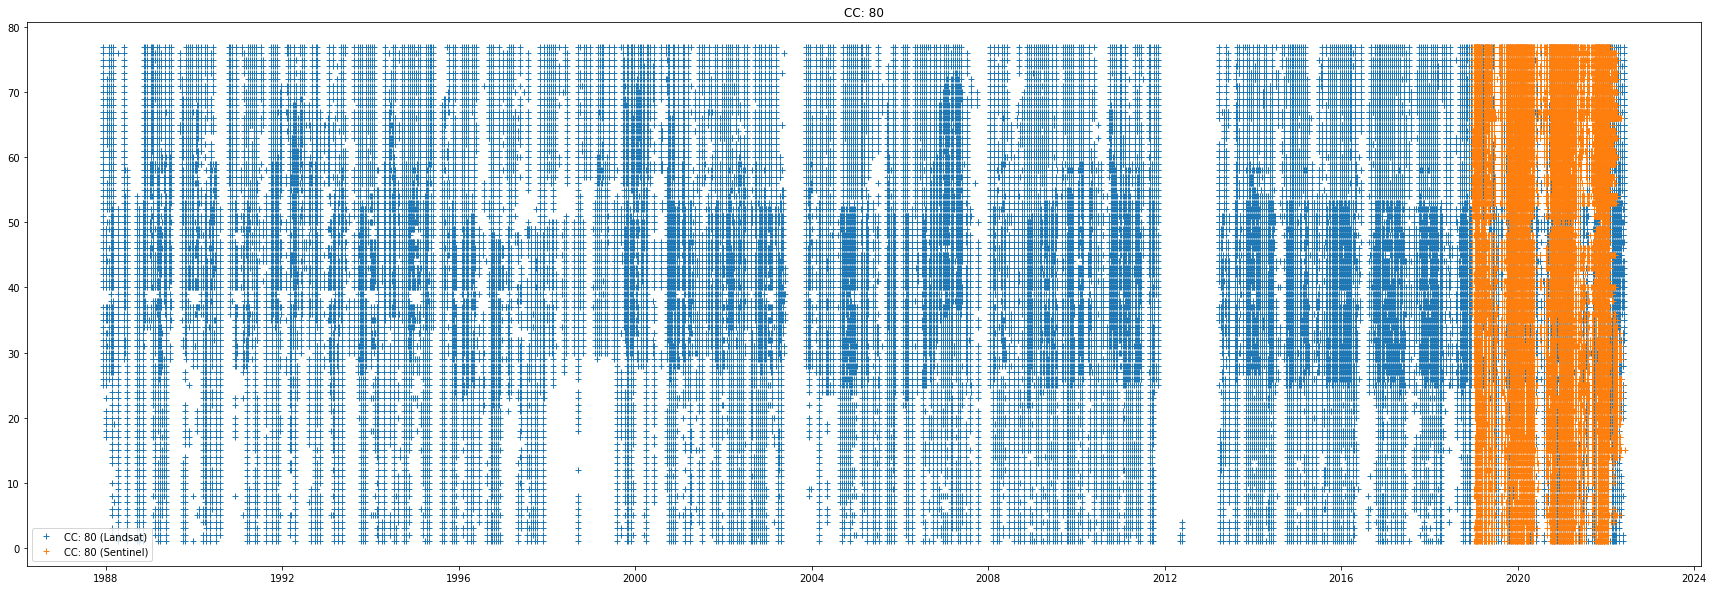

In [10]:
dfs = pd.read_csv("Lhasa/Lhasa_Sentinel_Data-CC-80.csv", index_col=0);
dfs["SENSING_TIME"] = dfs["SENSING_TIME"].map(partial(pd.to_datetime, unit='ms'));
dfs['BRAIDING_INDEX'] = (dfs['TOTAL_PERIM_SMOOTH']/2)/2000;

sentinel_min_time = dfs["SENSING_TIME"].min();
sentinel_max_time = dfs["SENSING_TIME"].max();
df = pd.read_csv(f"Lhasa/Lhasa_Data-CC-80.csv", index_col=0);
df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
df_crop = df[(df["SENSING_TIME"] >= sentinel_min_time) & (df["SENSING_TIME"] <= sentinel_max_time)];

plt.figure(figsize=(20, 6));
plt.title(f"CC: 80");
plt.plot(df_crop["SENSING_TIME"], df_crop["ID"], '+', label=f"CC: 80 (Landsat)");
plt.plot(dfs["SENSING_TIME"], dfs["ID"], '+', label=f"CC: 80 (Sentinel)");
plt.legend();

plt.figure(figsize=(30, 10));
plt.title(f"CC: 80");
plt.plot(df["SENSING_TIME"], df["ID"], '+', label=f"CC: 80 (Landsat)");
plt.plot(dfs["SENSING_TIME"], dfs["ID"], '+', label=f"CC: 80 (Sentinel)");
plt.legend();

In [18]:
# CUMULATIVE GCD --- try to figure out & find the smallest spacing interval

a = (dfs[dfs['ID'] == 5]['SENSING_TIME']
 .sort_values().diff()[1:]
 .map(lambda t: t.days)
 .reset_index(drop=True))

print(a)
# GCD at each stage
last_gcd = a[0]
gcd_pairs = [(0, a[0])];
for k, v in enumerate(a[1:]):
    cur_gcd = np.gcd(last_gcd, v);
    if(cur_gcd != last_gcd):
        gcd_pairs.append((k+1, cur_gcd))
    last_gcd = cur_gcd
print(gcd_pairs)

0       4
1       5
2       4
3       5
4       4
       ..
135     4
136     5
137     9
138     9
139    20
Name: SENSING_TIME, Length: 140, dtype: int64
[(0, 4), (1, 1)]


In [8]:
df = df80.copy();
first = df[df["SENSING_TIME"] > "2022-05-30"];
# first

In [9]:
df = df80.copy();
data = df[df["SENSING_TIME"] == df["SENSING_TIME"].max()];
# data

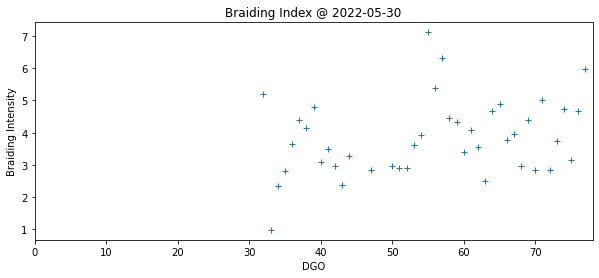

In [71]:
data = data.sort_values("ID");
idxs = np.arange(1, 78);
arr = np.full(77, np.nan);
for k, v in data.iterrows():
    arr[v['ID']-1] = v['BRAIDING_INDEX'];
plt.figure(figsize=(10,4));
plt.plot(idxs, arr, "+");
plt.title("Braiding Index @ 2022-05-30");
plt.xlabel("DGO");
plt.ylabel("Braiding Intensity");
plt.xlim(0, 78);

In [46]:
np.arange(1, 78)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77])

(77, 310)
(77, 155)
(77, 78)


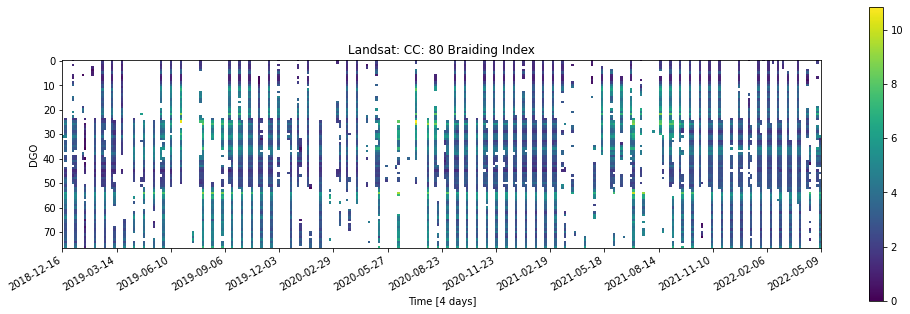

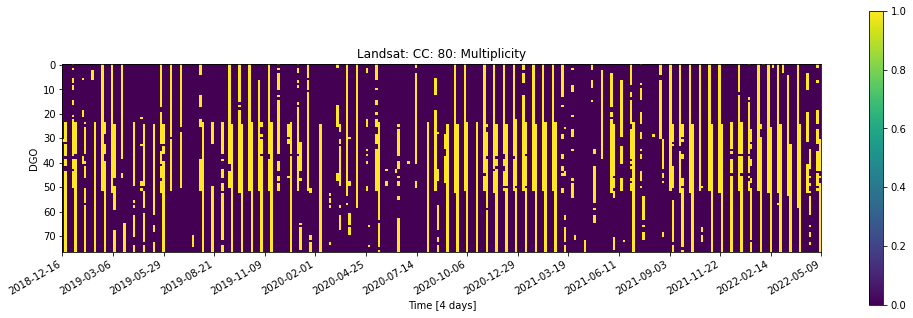

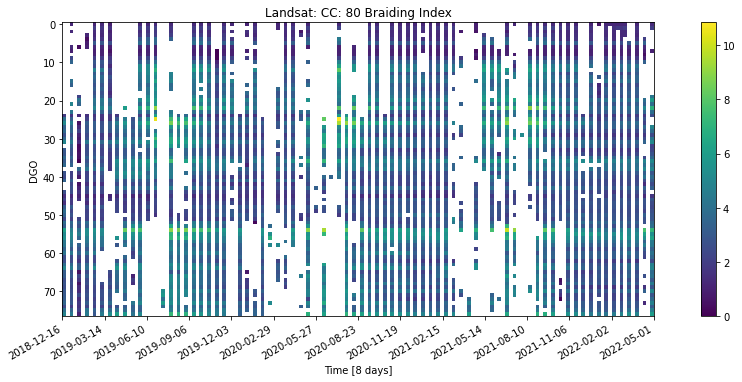

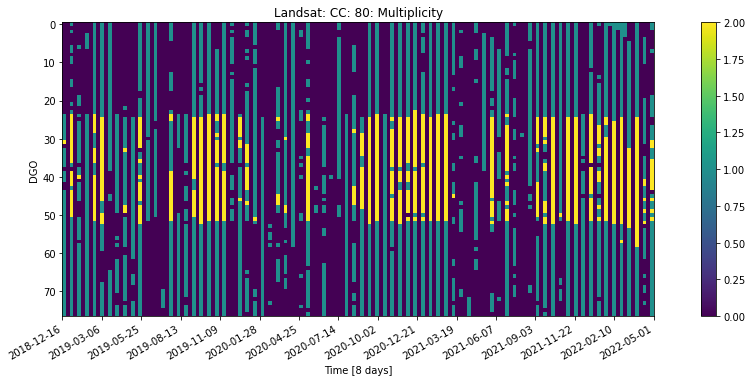

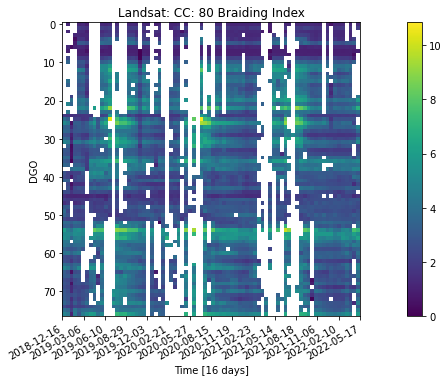

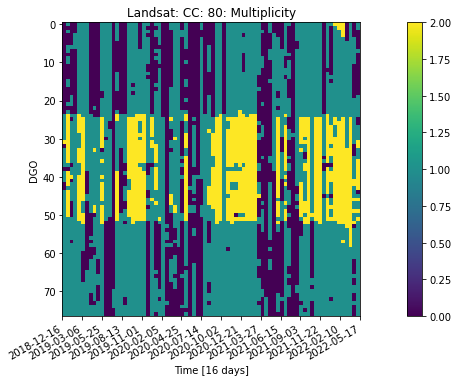

In [17]:
class CustomFormatter(Formatter):
    def __init__(self, min_time, days, fmt='%Y-%m-%d'):
        self.min_time = min_time;
        self.days = days;
        self.fmt = fmt;
    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x));
        return (self.min_time + pd.DateOffset(days=self.days*ind)).strftime(self.fmt);

def plot_dataframe(df, title, d = 8):
    # df = df.groupby(["x", "t"]).mean().reset_index()
    df = df.groupby(["ID", "SENSING_TIME"]).max().reset_index();
    
    
    df["t"] = (df["SENSING_TIME"] - df["SENSING_TIME"].min()).map(lambda t: t.days // d).astype(int);
    df["x"] = df["ID"] - df["ID"].min();
    
    Z = np.full((df["x"].max()+1, df["t"].max()+1), np.nan);
    M = np.full((df["x"].max()+1, df["t"].max()+1), 0);
    print(Z.shape)
    for k, v in df[["x", "t", "BRAIDING_INDEX"]].iterrows():
        x = v["x"].astype(int);
        t = v["t"].astype(int);
        if(M[x, t] == 0):
            Z[x, t] = v["BRAIDING_INDEX"];
        else:
            Z[x, t] = (Z[x, t]*M[x, t] + v["BRAIDING_INDEX"])/(M[x, t] + 1);
    #           Z[x, t] = max(Z[x, t], v["BRAIDING_INDEX"]) # TAKE MAX INSTEAD OF MEAN
        M[x, t] += 1;

    # TODO: PRESERVE MULTIPLICITY INFORMATION! ALSO TILE INDEX
    # ALWAYS BE ABLE TO WORK BACKWARDS TO TILE ID FROM IMAGE

    plt.figure(figsize=(17, 6));
    plt.imshow(Z, interpolation='none');
    # plt.xlim([0, 200]);
    plt.colorbar();
    plt.xlabel(f'Time [{d} days]');
    plt.ylabel('DGO');
    plt.title(f'{title} Braiding Index');
    plt.gca().xaxis.set_major_locator(LinearLocator(numticks=15))
    plt.gca().xaxis.set_major_formatter(CustomFormatter(sentinel_min_time, d))
    plt.gcf().autofmt_xdate()

#     xt_data = Z.copy()
#     mask = np.ones(xt_data.shape);
#     mask[np.isnan(xt_data)] = 0;
#     xt_data[np.isnan(xt_data)] = 0;

#     sigma = 0.05
#     tau = 0.99/(1 + 4*sigma);
#     xt_cp, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask,
#         lamb=np.array([0.001, 0.05]),
#         tau=tau,sigma=sigma,Niter=5000)
#     plt.figure(figsize=(17, 6));
#     plt.imshow(xt_cp);
#     plt.xlim([0, 200]);
#     plt.colorbar();
#     plt.xlabel(f'Time [{d} days]');
#     plt.ylabel('DGO');
#     plt.title(f'{title}: Braiding Index (Chambolle-Pock)');
#     plt.gca().xaxis.set_major_locator(LinearLocator(numticks=10))
#     plt.gca().xaxis.set_major_formatter(CustomFormatter(dates))
#     plt.gcf().autofmt_xdate()

    plt.figure(figsize=(17, 6));
    plt.imshow(M, interpolation='none');
    # plt.xlim([0, 200]);
    plt.colorbar();
    plt.xlabel(f'Time [{d} days]');
    plt.ylabel('DGO');
    plt.title(f'{title}: Multiplicity');
    plt.gca().xaxis.set_major_locator(LinearLocator(numticks=16))
    plt.gca().xaxis.set_major_formatter(CustomFormatter(sentinel_min_time, d))
    plt.gcf().autofmt_xdate()
    # scipy.io.savemat('save_location/'+title+'.mat', dict(xt=Z, xt_cp=xt_cp, xt_m=M));
    
    return Z, M;
    
df = df80.copy();
df = df[(df["SENSING_TIME"] >= sentinel_min_time) & (df["SENSING_TIME"] <= sentinel_max_time)];
df = df.groupby(["ID", "SENSING_TIME"]).max().reset_index()
ls4, ls4m = plot_dataframe(df, "Landsat: CC: 80", d=4);
plot_dataframe(df, "Landsat: CC: 80", d=8);
plot_dataframe(df, "Landsat: CC: 80", d=16);

# df = df50.copy();
# df = df[(df["SENSING_TIME"] >= sentinel_min_time) & (df["SENSING_TIME"] <= sentinel_max_time)];
# df = df.groupby(["ID", "SENSING_TIME"]).max().reset_index()
# plot_dataframe(df, "Landsat: CC: 50", d=4);

# df = df25.copy();
# df = df[(df["SENSING_TIME"] >= sentinel_min_time) & (df["SENSING_TIME"] <= sentinel_max_time)];
# df = df.groupby(["ID", "SENSING_TIME"]).max().reset_index()
# plot_dataframe(df, "Landsat: CC: 25", d=4);

(77, 159)


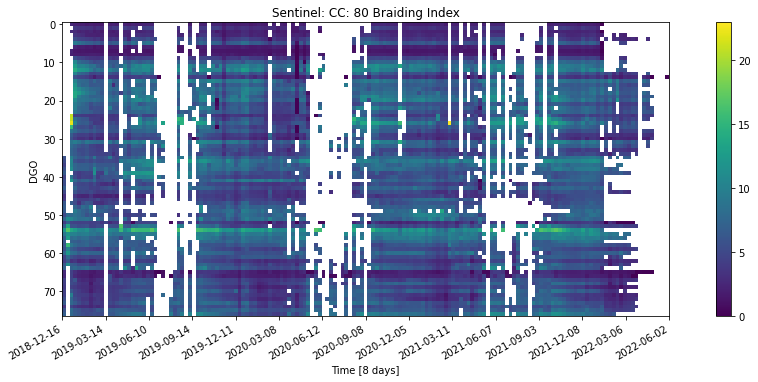

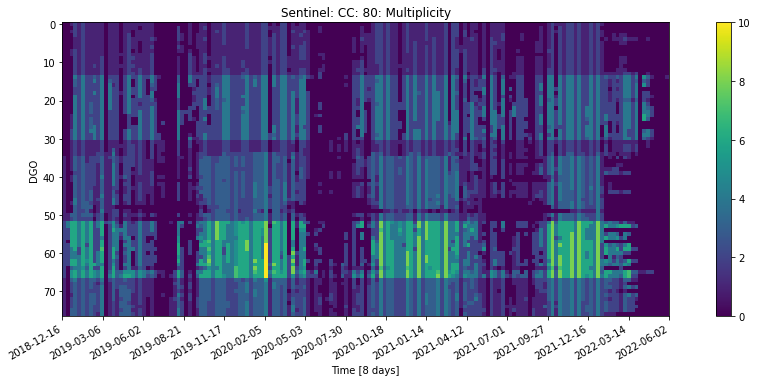

In [16]:
df = pd.read_csv("Lhasa/Lhasa_Sentinel_Data-CC-80.csv", index_col=0);
df["SENSING_TIME"] = df_s["SENSING_TIME"].map(partial(pd.to_datetime, unit='ms'));
df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
plot_dataframe(df, "Sentinel: CC: 80", d=8);
# TODO: Rectify axis labels
# Nelly: Talk about giving Barbara a list of dates/dgos we want to validate
# Before end of this week!

# We can check if it's possible to get data in BIG missing region.
# Data with more cloud but for much higher resolution images. (Better dataset)
# MAKE SURE TO DOCUMENT INSTALLATION PROCEDURE OF GEEMAP!!
#trytomakework for another person


# df = pd.read_csv("Lhasa/Lhasa_Sentinel_Data-CC-80.csv", index_col=0);
# df["SENSING_TIME"] = df_s["SENSING_TIME"].map(partial(pd.to_datetime, unit='ms'));
# df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;
# plot_dataframe(df, d=4);